# Coursework 1 - Crypto

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'  # multiple output per jupyter notebook code block

In [3]:
# lodaing data
btc_data = pd.read_parquet('data/bitcoin_historical_data.parquet')
factor_data = pd.read_parquet('data/hw1_factors.parquet')

# data format transformation: string -> float
btc_data['Price'] = btc_data['Price'].str.replace(',', '').astype(float)
factor_data['mkt_rf'] = factor_data['mkt_rf'].astype(float)

# convert to datetime object
btc_data['Date'] = pd.to_datetime(btc_data['Date'])
factor_data['Date'] = pd.to_datetime(factor_data['dt'])

# sort datetime
btc_data.sort_values(by='Date', ascending=True, inplace=True)
btc_data.reset_index(inplace=True, drop=True)

# converting mkt

In [4]:
btc_data.head()
factor_data.head()

,Date,Price,Open,High,Low,Vol.
0,2010-07-18,0.1,0.0,0.1,0.1,0.08K
1,2010-07-19,0.1,0.1,0.1,0.1,0.57K
2,2010-07-20,0.1,0.1,0.1,0.1,0.26K
3,2010-07-21,0.1,0.1,0.1,0.1,0.58K
4,2010-07-22,0.1,0.1,0.1,0.1,2.16K


,dt,mkt_rf,smb,hml,rmw,cma,rf,mom,Date
0,1963-07-01,-0.67,0.02,-0.35,0.03,0.13,0.012,-0.21,1963-07-01
1,1963-07-02,0.79,-0.28,0.28,-0.08,-0.21,0.012,0.42,1963-07-02
2,1963-07-03,0.63,-0.18,-0.10,0.13,-0.25,0.012,0.41,1963-07-03
3,1963-07-05,0.40,0.09,-0.28,0.07,-0.30,0.012,0.07,1963-07-05
4,1963-07-08,-0.63,0.07,-0.20,-0.27,0.06,0.012,-0.45,1963-07-08


<Figure size 1000x500 with 0 Axes>

Text(0.5, 1.0, 'Bitcoin Price Over Time')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price (USD)')

(array([13879., 14610., 15340., 16071., 16801., 17532., 18262., 18993.,
        19723.]),
 [Text(13879.0, 0, '2008'),
  Text(14610.0, 0, '2010'),
  Text(15340.0, 0, '2012'),
  Text(16071.0, 0, '2014'),
  Text(16801.0, 0, '2016'),
  Text(17532.0, 0, '2018'),
  Text(18262.0, 0, '2020'),
  Text(18993.0, 0, '2022'),
  Text(19723.0, 0, '2024')])

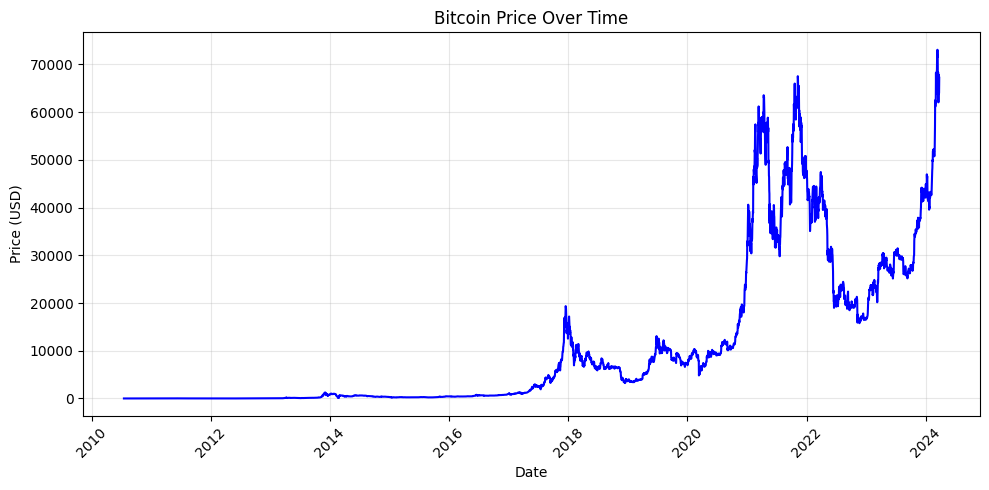

In [5]:
# plot btc_data['Price'] against btc_data['Date']
plt.figure(figsize=(10, 5))
plt.plot(btc_data['Date'], btc_data['Price'], color='blue', linewidth=1.5)
plt.title('Bitcoin Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Q1: Calculation
1. Average arithmetic return
2. Average geometric return
3. Volatility
4. Sharpe ratio
5. 10th, 50th and 90th percentile daily returns

all should be annualised.

### Bitcoin

In [6]:
# define a function for above calculation, since we will re-use it multiple times
def calc_stats(returns: pd.Series, periods_per_year=252) -> dict:
  '''
  returns (pd.Series): Array of return (assuming daily)
  periods_per_year: 252 for daily and 12 for monthly data
  return:
    dict: Dictionary containing the calculated statistics:
      - arithmetic_return (float): Annual arithmetic mean return
      - geometric_return (float): Annual geometric mean return
      - volatility (float): Annual volatility
      - sharpe_ratio (float): Annual sharpe ratio
      - percentile_10: 10th percentile return
      - percentile_50: 50th percentile return
      - percentile_90: 90th percentile return
  '''

  arith_return = returns.mean() * periods_per_year
  geo_return = (1 + returns).prod() ** (periods_per_year/returns.count()) - 1
  vol = returns.std() * np.sqrt(periods_per_year)
  sharpe_ratio = (returns.mean() / returns.std()) * np.sqrt(periods_per_year)
  percentiles = returns.quantile([0.1, 0.5, 0.9])

  return {
    'arith_return': arith_return,
    'geo_return': geo_return,
    'vol': vol,
    'sharpe_ratio': sharpe_ratio,
    'percentile_10': percentiles.get(0.1),
    'percentile_50': percentiles.get(0.5),
    'percentile_90': percentiles.get(0.9)
  }

In [7]:
# calculate full sample stats
btc_data['Return'] = btc_data['Price'].pct_change()
btc_stats_full_sample = calc_stats(btc_data['Return'])
pd.Series(btc_stats_full_sample)

arith_return     1.195586
geo_return       0.967075
vol              1.214798
sharpe_ratio     0.984185
percentile_10   -0.038671
percentile_50    0.000000
percentile_90    0.047108
dtype: float64

In [8]:
# post-2017
btc_returns_post_2017 = btc_data[btc_data['Date'] >= '2017-01-01']['Return']
btc_stats_post_2017 = calc_stats(btc_returns_post_2017)
pd.Series(btc_stats_post_2017)

arith_return     0.597210
geo_return       0.499629
vol              0.616230
sharpe_ratio     0.969135
percentile_10   -0.038656
percentile_50    0.001383
percentile_90    0.045192
dtype: float64

In [9]:
btc_returns_pre_2017 = btc_data[btc_data['Date'] < '2017-01-01']['Return']
btc_stats_pre_2017 = calc_stats(btc_returns_pre_2017)
pd.Series(btc_stats_pre_2017)

arith_return     1.865524
geo_return       1.665326
vol              1.643202
sharpe_ratio     1.135298
percentile_10   -0.038551
percentile_50    0.000000
percentile_90    0.052456
dtype: float64

In [10]:
# combine in a dataframe
btc_stats_df = pd.DataFrame([btc_stats_full_sample, btc_stats_post_2017, btc_stats_pre_2017], 
                            index=['BTC Full Sample', 'BTC Post-2017', 'BTC Pre-2017'])
btc_stats_df

,arith_return,geo_return,vol,sharpe_ratio,percentile_10,percentile_50,percentile_90
BTC Full Sample,1.195586,0.967075,1.214798,0.984185,-0.038671,0.000000,0.047108
BTC Post-2017,0.597210,0.499629,0.616230,0.969135,-0.038656,0.001383,0.045192
BTC Pre-2017,1.865524,1.665326,1.643202,1.135298,-0.038551,0.000000,0.052456


### US market

In [11]:
# construct non-excess return
mkt_returns = (factor_data['mkt_rf'] + factor_data['rf'])/100
mkt_stats_full_sample = calc_stats(mkt_returns)
pd.Series(mkt_stats_full_sample)

arith_return     0.114931
geo_return       0.107119
vol              0.161840
sharpe_ratio     0.710156
percentile_10   -0.010300
percentile_50    0.000700
percentile_90    0.010880
dtype: float64

In [12]:
mkt_data_post_2017 = factor_data[factor_data['Date'] >= '2017-01-01'][['mkt_rf', 'rf']]
# data is in percentage(?)
mkt_ret_post_2017 = (mkt_data_post_2017['mkt_rf'] + mkt_data_post_2017['rf'])/100
mkt_stats_post_2017 = calc_stats(mkt_ret_post_2017)
pd.Series(mkt_stats_post_2017)

arith_return     0.158060
geo_return       0.149857
vol              0.191280
sharpe_ratio     0.826327
percentile_10   -0.011700
percentile_50    0.000760
percentile_90    0.012310
dtype: float64

In [13]:
mkt_data_pre_2017 = factor_data[factor_data['Date'] < '2017-01-01'][['mkt_rf', 'rf']]
mkt_ret_pre_2017 = (mkt_data_pre_2017['mkt_rf'] + mkt_data_pre_2017['rf'])/100
mkt_stats_pre_2017 = calc_stats(mkt_ret_pre_2017)
pd.Series(mkt_stats_pre_2017)

arith_return     0.108556
geo_return       0.100938
vol              0.157024
sharpe_ratio     0.691333
percentile_10   -0.010170
percentile_50    0.000690
percentile_90    0.010592
dtype: float64

In [14]:
mkt_stats_df = pd.DataFrame([mkt_stats_full_sample, mkt_stats_post_2017, mkt_stats_pre_2017], 
                            index=['MKT Full Sample', 'MKT Post-2017', 'MKT Pre-2017'])
mkt_stats_df

,arith_return,geo_return,vol,sharpe_ratio,percentile_10,percentile_50,percentile_90
MKT Full Sample,0.114931,0.107119,0.161840,0.710156,-0.01030,0.00070,0.010880
MKT Post-2017,0.158060,0.149857,0.191280,0.826327,-0.01170,0.00076,0.012310
MKT Pre-2017,0.108556,0.100938,0.157024,0.691333,-0.01017,0.00069,0.010592


In [15]:
result_df = pd.concat([btc_stats_df, mkt_stats_df])
result_df

,arith_return,geo_return,vol,sharpe_ratio,percentile_10,percentile_50,percentile_90
BTC Full Sample,1.195586,0.967075,1.214798,0.984185,-0.038671,0.000000,0.047108
BTC Post-2017,0.597210,0.499629,0.616230,0.969135,-0.038656,0.001383,0.045192
BTC Pre-2017,1.865524,1.665326,1.643202,1.135298,-0.038551,0.000000,0.052456
MKT Full Sample,0.114931,0.107119,0.161840,0.710156,-0.010300,0.000700,0.010880
MKT Post-2017,0.158060,0.149857,0.191280,0.826327,-0.011700,0.000760,0.012310
MKT Pre-2017,0.108556,0.100938,0.157024,0.691333,-0.010170,0.000690,0.010592


Question: Which asset carries higher risk, US equi8es or Bitcoin? In terms of Sharpe, and then in terms
of drawdown.

Answer: 
Looking at volatility, Bitcoin's numbers are significantly higher than the market's. For example, Bitcoin's volatility in the full sample is 1.214798, while the market's is 0.161840. This indicates that Bitcoin is much more volatile and thus riskier in terms of price fluctuations. Regarding the 10th percentile, Bitcoin's worst 10% of returns are more negative than the market's, which also points to higher risk.

Comparing the Sharpe ratios, Bitcoin generally has a higher Sharpe ratio than the market, especially in the pre-2017 period. This suggests that Bitcoin has been providing better risk-adjusted returns.

Conclusion: Bitcoin generally has a higher Sharpe ratio than US equities, suggesting better risk-adjusted returns. However, this does not solely determine risk. Bitcoin exhibits significantly higher volatility and more negative 10th percentile returns compared to US equities. This indicates that Bitcoin is riskier in terms of drawdowns and overall volatility.

## Q2

## Q3

In [31]:
merged_df = pd.merge(btc_data, factor_data, how='inner', on='Date')

# construct BTC excess return
merged_df['btc_rf'] = merged_df['Return']*100 - merged_df['rf']

# run regression
X = sm.add_constant(merged_df['mkt_rf'])
y = merged_df['btc_rf']
model1 = sm.OLS(y, X).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 btc_rf   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     23.96
Date:                Tue, 04 Feb 2025   Prob (F-statistic):           1.03e-06
Time:                        12:35:34   Log-Likelihood:                -12195.
No. Observations:                3444   AIC:                         2.439e+04
Df Residuals:                    3442   BIC:                         2.441e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5457      0.142      3.830      0.000       0.266       0.825
mkt_rf         0.6221      0.127      4.895      0.000       0.373       0.871
==============================================================================
Omnibus:                     7649.348   Durbin-Watson:                   2.100
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         85790244.258
Skew:                          19.868   Prob(JB):                         0.00
Kurtosis:                     775.180   Cond. No.                         1.13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [32]:
# pre-2017
filtered_df = merged_df[merged_df['Date'] <= '2017-12-31']

X = sm.add_constant(filtered_df['mkt_rf'])
y = filtered_df['btc_rf']
model2 = sm.OLS(y, X).fit()
model2.summary()

# post-2016
filtered_df2 = merged_df[merged_df['Date'] >= '2016-01-01']
model3 = sm.OLS(filtered_df2['btc_rf'], sm.add_constant(filtered_df2['mkt_rf'])).fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 btc_rf   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.2105
Date:                Tue, 04 Feb 2025   Prob (F-statistic):              0.646
Time:                        12:35:36   Log-Likelihood:                -7120.2
No. Observations:                1878   AIC:                         1.424e+04
Df Residuals:                    1876   BIC:                         1.426e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9335      0.248      3.762      0.000       0.447       1.420
mkt_rf         0.1229      0.268      0.459      0.646      -0.402       0.648
==============================================================================
Omnibus:                     3933.733   Durbin-Watson:                   2.105
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         20992541.460
Skew:                          17.117   Prob(JB):                         0.00
Kurtosis:                     519.820   Cond. No.                         1.11
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 btc_rf   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     135.5
Date:                Tue, 04 Feb 2025   Prob (F-statistic):           2.27e-30
Time:                        12:35:36   Log-Likelihood:                -5770.6
No. Observations:                2069   AIC:                         1.155e+04
Df Residuals:                    2067   BIC:                         1.156e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2088      0.087      2.410      0.016       0.039       0.379
mkt_rf         0.8437      0.072     11.639      0.000       0.702       0.986
==============================================================================
Omnibus:                      248.371   Durbin-Watson:                   2.036
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2383.860
Skew:                           0.119   Prob(JB):                         0.00
Kurtosis:                       8.253   Cond. No.                         1.20
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Q4

In [28]:
merged_df = pd.merge(btc_data, factor_data, how='inner', on='Date')
merged_df['btc_rf'] = merged_df['Return']*100 - merged_df['rf']
filtered_df = merged_df[merged_df['Date'] >= '2017-01-01']

X = sm.add_constant(filtered_df[['mkt_rf', 'smb', 'hml', 'rmw', 'cma', 'mom']])
y = filtered_df['btc_rf']
model3 = sm.OLS(y, X).fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 btc_rf   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     26.64
Date:                Tue, 04 Feb 2025   Prob (F-statistic):           1.50e-30
Time:                        12:31:36   Log-Likelihood:                -5118.0
No. Observations:                1817   AIC:                         1.025e+04
Df Residuals:                    1810   BIC:                         1.029e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2234      0.095      2.343      0.019       0.036       0.410
mkt_rf         0.8172      0.084      9.720      0.000       0.652       0.982
smb            0.3783      0.159      2.383      0.017       0.067       0.690
hml           -0.3127      0.150     -2.078      0.038      -0.608      -0.018
rmw           -0.3598      0.201     -1.792      0.073      -0.754       0.034
cma            0.0590      0.273      0.216      0.829      -0.477       0.595
mom           -0.0467      0.092     -0.506      0.613      -0.228       0.134
==============================================================================
Omnibus:                      211.241   Durbin-Watson:                   2.046
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1883.225
Skew:                           0.128   Prob(JB):                         0.00
Kurtosis:                       7.981   Cond. No.                         4.20
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""